In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
data_dir = '/content/drive/MyDrive/Dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=6, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=3)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=3)



In [4]:
class_name = {'1': 'Normal', '2': 'COVID', '3': 'Pneumonia'}
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(25088, 3)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [6]:
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [7]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [8]:
torch.cuda.empty_cache()
def train_classifier():
    epochs = 10
    steps = 0
    print_every = 10

    model.to('cuda')

    for e in range(epochs):

        model.train()

        running_loss = 0

        for images, labels in iter(train_loader):
          if torch.cuda.is_available():
            steps += 1

            images, labels = images.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:

                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validate_loader, criterion)

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))

                running_loss = 0
                model.train()

train_classifier()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()
    model.to('cuda')

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
    
            images, labels = images.to('cuda'), labels.to('cuda')
    
            output = model.forward(images)

            probabilities = torch.exp(output)
            #print(output)
            #print(probabilities)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
            print(equality.type(torch.FloatTensor).mean())
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))   
        
        
test_accuracy(model, test_loader)

tensor(0.3333)
tensor(0.6667)
tensor(1.)
tensor(0.6667)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
Test Accuracy: 0.8666666746139526


In [10]:
model2 = torch.load("/content/drive/MyDrive/checkpoint.pth")
print(type(model))
print(type(model2))

<class 'torchvision.models.vgg.VGG'>
<class 'dict'>


In [11]:
def save_checkpoint(model):
    model.class_to_idx = training_dataset.class_to_idx
    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(model)

In [12]:
from collections import OrderedDict

# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'vgg16':
        
        model = models.vgg16(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(25088, 102)),
                                            ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model



In [13]:
from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
      pil_image.thumbnail((5000, 256))
    elif pil_image.size[0] > pil_image.size[1]:
      pil_image.thumbnail((256, 5000))
    elif pil_image.size[0] == pil_image.size[1]:
      pil_image.thumbnail((224, 5000))
    
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

In [ ]:
#import cv2
#pil_image = Image.open('/content/drive/MyDrive/Dataset/test/3/151-Pneumonia.png')

#pil_image.thumbnail((5000, 256))
#left_margin = (pil_image.width-224)/2
#bottom_margin = (pil_image.height-224)/2
#right_margin = left_margin + 224
#top_margin = bottom_margin + 224
#pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
#dir = '/content/drive/MyDrive/Dataset/test/3/Pneumonia.png'
#cv2.imwrite(dir,pil_image)
#probs, classes = predict(dir, model) 
#print(probs)

#print(classes)

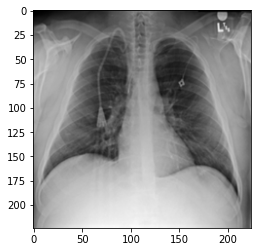

In [14]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('/content/drive/MyDrive/Dataset/test/1/45-Normal.png')
imshow(image)

In [22]:
def predict(image_path, model, topk=3):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes
    

probs, classes = predict('/content/drive/MyDrive/Dataset/test/1/44-Normal.png', model) 
print(probs)
print(classes)

[0.9999797344207764, 2.0296225557103753e-05, 5.398680169577119e-09]
['1', '2', '3']


In [23]:
probs, classes = predict('/content/drive/MyDrive/Dataset/test/3/145-Pneumonia.png', model) 
print(probs)
print(classes[0])

[0.999900221824646, 9.97499591903761e-05, 1.259112991647271e-08]
3


In [27]:
probs, classes = predict('/content/drive/MyDrive/Dataset/test/2/94-COVID.png', model) 
print(probs)
print(classes[0])


[0.9916487336158752, 0.008348924107849598, 2.236575028291554e-06]
2


In [29]:
import os
actual = []
predicted = []
f = 0
dir1 = "/content/drive/MyDrive/Dataset/test"
for folder in os.listdir(dir1):
  dir2 = "/content/drive/MyDrive/Dataset/test/" + folder + "/"
  for img in os.listdir(dir2):
    if not img.startswith('.'):
      imageLoc = dir2 + img
      if folder == "1":
          actual.append(1)
          probs, classes = predict(imageLoc, model) 
          predicted.append(int(classes[0]))
      elif folder == "2":
          actual.append(2)
          probs, classes = predict(imageLoc, model) 
          predicted.append(int(classes[0]))
      elif folder == "3":
          actual.append(3)
          probs, classes = predict(imageLoc, model) 
          predicted.append(int(classes[0]))
print(actual)
print(predicted)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2]


In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = confusion_matrix(actual,predicted,labels=[1,2,3])
print(matrix)
matrix = classification_report(actual,predicted,labels=[1,2,3])
print(matrix)

[[ 7  3  0]
 [ 0  9  1]
 [ 0  0 10]]
              precision    recall  f1-score   support

           1       1.00      0.70      0.82        10
           2       0.75      0.90      0.82        10
           3       0.91      1.00      0.95        10

    accuracy                           0.87        30
   macro avg       0.89      0.87      0.86        30
weighted avg       0.89      0.87      0.86        30

